# Data Wrangling Project 1.0
### Thanasak Harisombut

Date: 01/11/2020

Version: 1.0

Environment: Python 3.7.4 and Jupyter notebook

### Libraries used:
* pandas (for data frame and operate some basic function such describe, filter, and count, included in Anaconda Python 3.7) 
* numpy (for using mathematical function such as log, power, mean, and included in Anaconda Python 3.7)
* sklearn (for scaling data, included in Anaconda Python 3.7)
* math (for calculting distance such radians, sin, included in Anaconda Python 3.7)
* scipy.stats (for making q-q plot, included in Anaconda Python 3.7)
* BeautifulSoup (for loading html dataset, included in Anaconda Python 3.7)
* xml.etree.ElementTree (for loading xml dataset, included in Anaconda Python 3.7)
* shapely (for dealing with geometrical data, included in Anaconda Python 3.7)
* shapefile (for loading shape file, included in Anaconda Python 3.7)
* pdfminer (for converting pdf file to text file)
* matplotlib (for plotting visualisation, included in Anaconda Python 3.7)


## Introduction

This project requires to understand various formats of input file, integration process and reshape data which are considibly important for datascientists. To complete it, I have broken down processes as shown below:

1. [Initital process](#1)
2. [Task 1: Data Integration](#2)
  1. [Load datasets from different formats](#2.1)
  2. [Integrate real estate dataframes](#2.2)
  3. [Check duplicated data](#2.3)
  4. [Assign suburb via shape file data](#2.4)
  5. [Create functions to Find nearest place and calculate distance](#2.5)
  6. [Integrate shopping center data](#2.6)
  7. [Integrate Melbourne train data](#2.7)
    1. [Find nearest train station and calculate distance](#2.7.1)
    2. [Calculate time travel and transfer flag](#2.7.2)
  8. [Integrate hospitals data](#2.8)
  9. [Integrate Supermarkets data](#2.9)
  10. [Write output file](#2.10)
3. [Task 2: data reshaping](#3)
  1. [Transformation](#3.1)
  2. [Standardisation](#3.2)
  3. [Summary](#3.3)
4. [Conclusion](#4)



# 1. Initial Process <a class="anchor" name="1"></a>
### Import libraries 


In [1]:
# Import libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
# !pip install shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
import shapefile
import math
from matplotlib import pyplot as plt
import scipy.stats as stats
from sklearn import preprocessing

import warnings; warnings.simplefilter('ignore')

# 2. Task 1: Data Integration <a class="anchor" name="2"></a>

In this task, we are required to integrate the 7 given datasets into a proper structure and the files were given in different extensions as follows:

- Hospitals dataset: hospitals.xlsx
- Supermarkets dataset: supermarkets.html
- Shopping centers dataset: shopingcenters.pdf
- Real estate dataset: real_state.json and real_state.xml
- Victoria shapefile: Vic_suburb_boundary
- Melbourne train data: GTFS_Melbourne_Train_Information

First, I'll load all datasets into pandas dataframe also combine and set appropriate datatypes.

## 2.1 Load datasets from different formats<a class="anchor" name="2.1"></a>

### real state json

In [2]:
# load json data 
f = open("real_state.json", "r")
json = f.read()

# convert json data to pandas dataframe
real_state_json_df = pd.read_json(json)


### real state xml

In [3]:
# function to convert xml data into Pandas dataframe
def xmlToDF(xml):
    # initial varibles
    etree = ET.fromstring(xml)
    cols = [e.tag for e in etree.getchildren()]
    data = {}
    
    # each columns
    for c in cols:
        data[c] = []
        
        # extract children in tag and store
        elements = etree.find(c).getchildren()
        for e in elements:
            data[c].append(e.text)
    
    return pd.DataFrame.from_dict(data)

# load data from file
f = open("real_state.xml", "r")
xml_content = f.read()

# call function to convert xml string to pandas dataframe
real_state_xml_df = xmlToDF(xml_content[2:-1])

## 2.2 Integrate real estate dataframes<a class="anchor" name="2.2"></a>

In [4]:
# integrate all major dataframes
df = pd.concat([real_state_json_df, real_state_xml_df])

# reset index of dataframe
df.reset_index(drop=True, inplace=True)

In [5]:
# assign datatypes to integrated dataframe
df = df.astype({'lat': float, 
           'lng': float,
           'price': int, 
           'year':int, 
           'bedrooms':int, 
           'bathrooms':int, 
           'parking_space':int
          })

### Check result

In [6]:
# check the result
print('Number of records:', len(df))
df.head()


Number of records: 2008


,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
0,17443,-37.698763,144.904939,55 Moonee Boulevard,5460000,house,2009,3,1,1
1,16783,-37.713242,144.947375,20 Talbot Street,5380000,house,2014,5,3,3
2,30499,-37.768795,144.992139,91 Arthurton Road,12600000,house,2016,3,2,1
3,35191,-37.703586,145.011277,54 Pickett Street,8190000,house,2016,3,1,1
4,24435,-37.711983,144.968473,48A Mutton Road,7350000,house,2010,3,2,1


## 2.3 Check duplicated records<a class="anchor" name="2.3"></a>

In [7]:
# check duplicated records
df[df[[c for c in df.columns.to_list() if c != 'property_id']]
   .duplicated(keep=False)].sort_values(by=['addr_street', 'property_id'])


,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space
6,91118,-37.972904,145.036312,1 McDonald Street,22100000,house,2014,3,2,2
1994,91118,-37.972904,145.036312,1 McDonald Street,22100000,house,2014,3,2,2
9,83458,-37.856960,145.002701,12/4 Rae Court,3591000,house,2008,1,1,1
1997,83458,-37.856960,145.002701,12/4 Rae Court,3591000,house,2008,1,1,1
13,92757,-38.000248,145.081278,15 Royal Parade,12400000,house,2015,4,2,3
2001,92757,-38.000248,145.081278,15 Royal Parade,12400000,house,2015,4,2,3
853,61344,-37.780513,145.251059,155 Plymouth Road,5313000,house,2012,3,1,0
1382,61344,-37.780513,145.251059,155 Plymouth Road,5313000,house,2012,3,1,0
15,4958,-37.868707,144.824481,17 Romawi Street,4592000,house,2010,4,3,2
2003,4958,-37.868707,144.824481,17 Romawi Street,4592000,house,2010,4,3,2


In [8]:
# count the duplicated records and show
count_dup = len(df[df[[c for c in df.columns.to_list() if c != 'property_id']]
               .duplicated(keep=False)].sort_values(by=['addr_street', 'property_id']))

print('As we can see, there are {} duplicated records.'.format(count_dup) ,end=' ')
print('Hence, they should be taken off from dataframe.')


As we can see, there are 46 duplicated records. Hence, they should be taken off from dataframe.


In [9]:
# drop duplicated rows
duplicated_list = df[df[[c for c in df.columns.to_list() if c != 'property_id']]
                       .duplicated(keep=False)].index.to_list()
df.drop(index=duplicated_list, inplace=True)

# reset index of dataframe
df.reset_index(drop=True, inplace=True)


### Check result

In [10]:
# check the result
print('Number of records:', len(df))

Number of records: 1962


## 2.4 Assign suburb via shape file data<a class="anchor" name="2.4"></a>

After extracting shape file `vic_suburb_boundary.zip` to a working directory. The shapely library is required to install for the first time. Simply execute command `!pip install shapely` in a coding block. Next, let read the file and have a look what included in it.


In [11]:
# load shape file
sf = shapefile.Reader("./supplementary_data/vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp")
recs = sf.records()
shapes = sf.shapes()

# check record data
recs[0].as_dict()

{'LC_PLY_PID': '6670',
 'DT_CREATE': datetime.date(2011, 8, 31),
 'DT_RETIRE': None,
 'LOC_PID': 'VIC2615',
 'VIC_LOCALI': datetime.date(2012, 4, 27),
 'VIC_LOCA_1': None,
 'VIC_LOCA_2': 'UNDERBOOL',
 'VIC_LOCA_3': '',
 'VIC_LOCA_4': '',
 'VIC_LOCA_5': 'G',
 'VIC_LOCA_6': None,
 'VIC_LOCA_7': '2'}

The attribute `VIC_LOCA_2` in the records variable has stored a suburb in Victoria state.

In [12]:
# check shape data
shapes[0].points[0:5]

[(141.74552399, -35.07228701),
 (141.74552471, -35.07201624),
 (141.74748471, -35.06367123),
 (141.74909525, -35.05681288),
 (141.74917403, -35.05647197)]

On the other hand, the attribute `points` in the shapes variable has stored latitude and longitude points.

Therefore, applying both shapes and records information, we can impute suburbs in dataframe.

In [13]:
%%time
# function to impute suburb from the shape file.
def get_suburb(lat,long):
    point = Point(long, lat)
    
    for i in range(len(shapes)):
        pg = Polygon(shapes[i].points)
        if point.within(pg):
            return(recs[i].VIC_LOCA_2)
    return('not available')

# impute suburb data via get_suburb function
df['suburb'] = 'not available'
for i,row in df.iterrows():
    df['suburb'][i] = get_suburb(row.lat, row.lng)
    

CPU times: user 2min 20s, sys: 713 ms, total: 2min 20s
Wall time: 2min 21s


### Check the result

In [14]:
# check not available suburb
print('not available suburb:', len(df[df['suburb']=='not available']), 'records')

# check value of new column
df.suburb.head()

not available suburb: 0 records


0      GLENROY
1    NORTHCOTE
2      FAWKNER
3       COBURG
4       KEALBA
Name: suburb, dtype: object

## 2.5 Create functions to Find nearest place and calculate distance<a class="anchor" name="2.5"></a>


In [15]:
# function to calculate between two locations
def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6378 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c
    return d

# function to find nearest_place from passing dataframe
def find_nearest_place_by_df(origin, df):
    # initial variables
    nearest_id = ""
    nearest_dist = 99999
    
    # find the closest place
    for i, item in df.iterrows():
        # calculate distance
        dist = distance(origin, [df.lat[i], df.lng[i]])
        
        # convert km to m
        dist = int(round(dist * 1000))
        
        # if nearest_dist is farther than new place, assign new place instead
        if dist < nearest_dist:
            nearest_id = df.id[i]
            nearest_dist = dist

    # return property_id and distance
    return([nearest_id, nearest_dist])
    

## 2.6 Integrate shopping center pdf data<a class="anchor" name="2.6"></a>

### Load dataset

Initially, extracting data from pdf file, it is not easy. Therefore, I would like to apply an external library called `pdfminer` and the command `!pip install pdfminer` is required to execute for the first time. After that running the command `!pdf2txt.py -o shopingcenters.txt shopingcenters.pdf` will activate the pdfminer to generate a new readable text file from the pdf file format.


In [16]:
#### RUN THIS COMMENTED CODE TO EXTRACT DATA FROM PDF FILE TO TEXT ####
# !pip install pdfminer
# !pdf2txt.py -o shopingcenters.txt shopingcenters.pdf
#######################################################################

In [17]:
# load extracted pdf file from text
pdfTxtFile = '/supplementary_data/shopingcenters.txt'
pdf_txt = open(pdfTxtFile, 'r')

# initital dataframe
shopping_center_df = pd.DataFrame(columns=[ 'id', 'lat', 'lng'])

# loop each line of text file
for line in pdf_txt:
    
    # split data by space
    row = line.split(' ')
    
    # check if the correct rows, then store data
    if len(row) > 1 and row[0].isnumeric:
        # set column names
        s = pd.Series(row, 
                      index=['index', 'id', 'lat', 'lng'],
                      dtype=str
                     )
        s[3] = s[3].replace('\n','')
        
        # append data to dataframe
        shopping_center_df = shopping_center_df.append(s[1:], ignore_index=True)

# assign datatypes
shopping_center_df = shopping_center_df.astype({'id': str, 'lat': float, 'lng': float})


### Find nearest place and calculate distance

In [18]:
# initial set of variables
place_name = 'Shopping_center_id'
dist_name = 'Distance_to_sc'

# set defualt values for new columns
df[place_name] = 'not available'
df[dist_name] = 0

# assign dataframe for look up data
look_up_df = shopping_center_df

# find nearest place and calculate distance for each record
for i, row in df.iterrows():
    look_up_id, dist = find_nearest_place_by_df([df.lat[i], df.lng[i]], look_up_df)
    df[place_name][i] = look_up_id
    df[dist_name][i] = dist
    

### Check result

In [19]:
# check not available value
print('not available Shopping_center_id:', len(df[df['Shopping_center_id']=='not available']), 'records')
print('not available Distance_to_sc:', len(df[df['Distance_to_sc']==0]), 'records\n')

# check basic stat info
print(df['Distance_to_sc'].describe())

# check the result
df[['Shopping_center_id','Distance_to_sc']].head()


not available Shopping_center_id: 0 records
not available Distance_to_sc: 0 records

count    1962.000000
mean     2459.299694
std      1320.772170
min        92.000000
25%      1434.000000
50%      2209.000000
75%      3337.000000
max      5957.000000
Name: Distance_to_sc, dtype: float64


,Shopping_center_id,Distance_to_sc
0,SC_059,2116
1,SC_103,3364
2,SC_030,2789
3,SC_030,2643
4,SC_107,1602


## 2.7 Integrate Melbourne train data<a class="anchor" name="2.7"></a>

### 2.7.1 Find nearest train station and calculate distance<a class="anchor" name="2.7.1"></a>

### Load dataset 

In order to find the nearest train station, the file `stops.txt` in `GTFS - Melbourne Train Information` directory is required. This file included stop_id and stop_name which are significant for the task.


In [20]:
# load stops data
train_stops_df = pd.read_csv('./supplementary_data/GTFS - Melbourne Train Information/stops.txt')

# rename of columns
train_stops_df.rename(columns={"stop_id": "id", 
                               "stop_name":"name", 
                               "stop_lat":"lat", 
                               "stop_lon":"lng"}, 
                      inplace=True)


### Find nearest place and calculate distance

In [21]:
# initial set of variables
place_name = 'Train_station_id'
dist_name = 'Distance_to_train_station'

# set defualt values for new columns
df[place_name] = 0
df[dist_name] = 0

# assign dataframe for look up data
look_up_df = train_stops_df

# find nearest place and calculate distance for each record
for i, row in df.iterrows():
    look_up_id, dist = find_nearest_place_by_df([df.lat[i], df.lng[i]], look_up_df)
    df[place_name][i] = look_up_id
    df[dist_name][i] = dist
    

### Check result

In [22]:
# check not available value
print('not available Train_station_id:', len(df[df['Train_station_id']==0]), 'records')
print('not available Distance_to_train_station:', len(df[df['Distance_to_train_station']==0]), 'records\n')

# check basic stat info
print(df['Distance_to_train_station'].describe())

# check the result
df[['Train_station_id','Distance_to_train_station']].head()

not available Train_station_id: 0 records
not available Distance_to_train_station: 0 records

count    1962.000000
mean     1402.247706
std       973.571957
min        26.000000
25%       673.750000
50%      1137.000000
75%      1923.750000
max      4875.000000
Name: Distance_to_train_station, dtype: float64


,Train_station_id,Distance_to_train_station
0,20031,1043
1,20016,301
2,19962,757
3,19966,730
4,20002,2685


### 2.7.2 Calculate time travel and transfer flag<a class="anchor" name="2.7.2"></a>

### Load datasets

To calculate time travel to CBD and transfer flag, there are three extra files need to be integrated as follow.

1. `calendar.txt` - seeking for service_id which run on weekdays.
2. `trips.txt` -  use to link between calendar and stop_times by service_id and trip_id.
3. `stop_times.txt` - to find any trips which operate between 7-9 am and extract travel time.


In [23]:
# load calendar data
train_calendar_df = pd.read_csv('./supplementary_data/GTFS - Melbourne Train Information/calendar.txt')

# select service_id which work on weekdays
weekdays_service_id = train_calendar_df[(train_calendar_df['monday']==1) 
                                      & (train_calendar_df['tuesday']==1) 
                                      & (train_calendar_df['wednesday']==1) 
                                      & (train_calendar_df['thursday']==1) 
                                      & (train_calendar_df['friday']==1) 
                                     ]['service_id'].tolist()
print('Service id:', weekdays_service_id)

Service id: ['T0']


Only the service_id 'T0' runs on weekdays. Thus, filtering the service_id on trips dataframe will optimise our performance once looking up data.

In [24]:
# load trips data
train_trips_df = pd.read_csv('./supplementary_data/GTFS - Melbourne Train Information/trips.txt')
print('Original records:', len(train_trips_df))

# filter only weekdays trips
train_trips_df = train_trips_df[train_trips_df.service_id.isin(weekdays_service_id)]

print('Filtered records:', len(train_trips_df))


Original records: 23809
Filtered records: 2323


In [25]:
# load stop_times data
train_stop_times_df = pd.read_csv('./supplementary_data/GTFS - Melbourne Train Information/stop_times.txt')
print('Original records:', len(train_stop_times_df))

# filter only trips which pass the Flinder station
flinder_station_id = int(train_stops_df[train_stops_df['name']=='Flinders Street Railway Station']['id'])
flinder_trip_id = train_stop_times_df[train_stop_times_df['stop_id']==flinder_station_id]['trip_id'].tolist()
train_stop_times_df = train_stop_times_df[train_stop_times_df.trip_id.isin(flinder_trip_id)]

# filter only weekdays trips
train_stop_times_df = train_stop_times_df[train_stop_times_df['trip_id'].isin(train_trips_df['trip_id'].tolist())]

print('Filtered records:', len(train_stop_times_df))


Original records: 390305
Filtered records: 41506


Filter the trips which operate on weekdays and pass the Flinder station will reduce processing time.

### Create function to calculate_travel_time

In [26]:
# function to find arrival trip by trip_id
def find_arrival_trip(trip_id, seq, destination_stop):
    
    dest_trip = train_stop_times_df[(train_stop_times_df['trip_id'] == trip_id) &
                                    (train_stop_times_df['stop_sequence'] > seq) &
                                    (train_stop_times_df['stop_id'] == destination_stop)
                                   ]
    return(dest_trip)

# function to subtract depart_time and arrival_time then return in mintue
def subtract_travel_time(depart_time, arrival_time):
    # split time in string into list [hh, mm, ss]
    depart_time_sp = depart_time.split(':')
    arrival_time_sp = arrival_time.split(':')
    
    # convert time in string to integer
    depart_time_min = (int(depart_time_sp[0]) * 60) + int(depart_time_sp[1])
    arrival_time_min = (int(arrival_time_sp[0]) * 60) + int(arrival_time_sp[1])
    
    # stract time in minute and return
    return(arrival_time_min - depart_time_min)

# function to calculate average travel_time
def calculate_travel_time(depart_station, destination_station, start_time = '07:00:00', end_time = '09:00:00'):
    # initial variable
    travel_time = [] # minute

    # find trips
    filtered_trips = train_stop_times_df[((train_stop_times_df['departure_time'] >= start_time) & 
                                        (train_stop_times_df['departure_time'] <= end_time)) &
                                        (train_stop_times_df['stop_id'] == depart_station)
                                       ]
    # select trips which depart between specific period
    for i, row in filtered_trips.iterrows():
        # find arrival_trip
        arrival_trip = find_arrival_trip(row.trip_id, row.stop_sequence, destination_station)
        
        if len(arrival_trip) > 0:
            # reset index of result data
            arrival_trip.reset_index(drop=True, inplace=True)
            arrival_time = arrival_trip.arrival_time[0]
            
            # keep the travel time
            travel_time.append(subtract_travel_time(row.departure_time, arrival_time))

    if (len(travel_time) > 0):
        # return average time travel in minute
        return(int(round(np.mean(travel_time))))
    else:
        return(0)


### Execute calculation travel time to CBD and transfer flag

In [27]:
# set defualt values for new columns travel_min_to_CBD and Transfer_flag
df['travel_min_to_CBD'] = 0
df['Transfer_flag'] = -1

# execute each record
for i, row in df.iterrows():
    # calculate travel time to Flinder station
    travel_time = calculate_travel_time(row.Train_station_id, flinder_station_id)
    
    # if find any direct route
    if travel_time > 0:
        df.Transfer_flag[i] = 0
        df.travel_min_to_CBD[i] = travel_time
    else: 
        # set Transfer_flag as 1 when there is no direct route
        df.Transfer_flag[i] = 1


### Check result

In [28]:
# check not available value
print('not available travel_min_to_CBD:', len(df[df['travel_min_to_CBD']==0]), 'records')
print('not available Transfer_flag:', len(df[df['Transfer_flag']==-1]), 'records\n')

# check basic stat info
print(df['travel_min_to_CBD'].describe())

# check the result
df[['travel_min_to_CBD','Transfer_flag']].head()

not available travel_min_to_CBD: 4 records
not available Transfer_flag: 0 records

count    1962.000000
mean       33.324159
std        12.391371
min         0.000000
25%        23.000000
50%        34.000000
75%        41.000000
max        60.000000
Name: travel_min_to_CBD, dtype: float64


,travel_min_to_CBD,Transfer_flag
0,35,0
1,20,0
2,33,0
3,26,0
4,33,0


## 2.8 Integrate hospitals data<a class="anchor" name="2.8"></a>

### Load dataset

In [29]:
# load hospitals dataset from xlsx file to dataframe
file_name_hospital = '/supplementary_data/hospitals.xlsx'
hospital_df = pd.read_excel(file_name_hospital, 
                            index_col=0, 
                            dtype={'id': str, 
                                   'lat': float, 
                                   'lng': float, 
                                   'name': str
                                  })


### Find nearest place and calculate distance

In [30]:
# initial set of variables
place_name = 'Hospital_id'
dist_name = 'Distance_to_hospital'

# set defualt values for new columns
df[place_name] = 'not available'
df[dist_name] = 0

# assign dataframe for look up data
look_up_df = hospital_df

# find nearest place and calculate distance for each record
for i, row in df.iterrows():
    look_up_id, dist = find_nearest_place_by_df([df.lat[i], df.lng[i]], look_up_df)
    df[place_name][i] = look_up_id
    df[dist_name][i] = dist
    

### Check result

In [31]:
# check not available value
print('not available Hospital_id:', len(df[df['Hospital_id']=='not available']), 'records')
print('not available Distance_to_hospital:', len(df[df['Distance_to_hospital']==0]), 'records\n')

# check basic stat info
print(df['Distance_to_hospital'].describe())

# check the result
df[['Hospital_id','Distance_to_hospital']].head()

not available Hospital_id: 0 records
not available Distance_to_hospital: 0 records

count    1962.000000
mean     2212.297655
std      1694.544702
min        69.000000
25%      1065.000000
50%      1748.000000
75%      2750.000000
max      9191.000000
Name: Distance_to_hospital, dtype: float64


,Hospital_id,Distance_to_hospital
0,hospital_184,4846
1,hospital_035,1530
2,hospital_139,2678
3,hospital_144,666
4,hospital_005,3401


## 2.9 Integrate Supermarkets data<a class="anchor" name="2.9"></a>

### Load dataset

In [32]:
# load html dataset with BeautifulSoup library
f = open("/supplementary_data/supermarkets.html", "r")
html = f.read()
bsobj = BeautifulSoup(html, "html.parser")

# initial empty lists
id_list = []
lat_list = []
lng_list = []
type_list = []

# seek for tbody tag
for tr in bsobj.find('table', {'class':'dataframe'}).find('tbody').findAll('tr'):
    # extract values from td tag
    prop_id, lat, lng, prop_type = tr.findAll('td')
    
    # append to the lists
    id_list.append(str(prop_id.contents[0]))
    lat_list.append(float(lat.contents[0]))
    lng_list.append(float(lng.contents[0]))
    type_list.append(str(prop_type.contents[0]))

# parsing lists to dataframe supermarket_df
supermarket_df = pd.DataFrame(
                        {'id': id_list,
                         'lat': lat_list,
                         'lng': lng_list,
                         'name': type_list
                        })


#### Check duplicated records

There is 2 duplicated records, however, the supermarket ids are different and I decided to keep them since assuming these could be 2 supermarkets located in the same shopping mall.


In [33]:
# check duplicated records
supermarket_df[supermarket_df[[c for c in supermarket_df.columns.to_list() if c != 'id']]
   .duplicated(keep=False)].sort_values(by=['lat', 'lng'])

,id,lat,lng,name
225,S_226,-37.86685,145.2204,Coles
226,S_227,-37.86685,145.2204,Coles


### Find nearest place and calculate distance

In [34]:
# initial set of variables
place_name = 'Supermarket_id'
dist_name = 'Distance_to_supermaket'

# set defualt values for new columns
df[place_name] = 'not available'
df[dist_name] = 0

# assign dataframe for look up data
look_up_df = supermarket_df

# find nearest place and calculate distance for each record
for i, row in df.iterrows():
    look_up_id, dist = find_nearest_place_by_df([df.lat[i], df.lng[i]], look_up_df)
    df[place_name][i] = look_up_id
    df[dist_name][i] = dist
    

### Check result

In [35]:
# check not available value
print('not available Supermarket_id:', len(df[df['Supermarket_id']=='not available']), 'records')
print('not available Distance_to_supermaket:', len(df[df['Distance_to_supermaket']==0]), 'records\n')

# check basic stat info
print(df['Distance_to_supermaket'].describe())

# check the result
df[['Supermarket_id','Distance_to_supermaket']].head()


not available Supermarket_id: 0 records
not available Distance_to_supermaket: 0 records

count    1962.000000
mean     1368.608563
std       671.774530
min        37.000000
25%       834.250000
50%      1311.000000
75%      1843.750000
max      2955.000000
Name: Distance_to_supermaket, dtype: float64


,Supermarket_id,Distance_to_supermaket
0,S_209,1862
1,S_105,2217
2,S_030,2369
3,S_173,964
4,S_222,1880


## 2.10 Write output file<a class="anchor" name="2.10"></a>

In [36]:
# set output columns
output_cols = ['property_id', 'lat', 'lng', 'addr_street', 'suburb', 'price', 'property_type',
               'year', 'bedrooms', 'bathrooms', 'parking_space',
               'Shopping_center_id', 'Distance_to_sc', 'Train_station_id',
               'Distance_to_train_station', 'travel_min_to_CBD', 'Transfer_flag',
               'Hospital_id', 'Distance_to_hospital', 'Supermarket_id',
               'Distance_to_supermaket']

# save output file in csv
df[output_cols].to_csv('solution.csv', index=False)

# 3. Task 2: data reshaping <a class="anchor" name="3"></a>


## 3.1 Transformation<a class="anchor" name="3.1"></a>

### Linear regression assumptions

As we are developing a Linear regression model, one of the key assumptions is the gaussian-like distribution. This will be boosting a model's performance. Hence, let investigate this aspect by plotting histogram, Q-Q plot, and the correlation between the target variable and selected features to see normality, and transform them into normally distributed as much as possible.


### Exploration

First of all, I would like to investigate the nature of focusing attributes.

In [37]:
df[['price','Distance_to_sc','travel_min_to_CBD','Distance_to_hospital']].describe()

,price,Distance_to_sc,travel_min_to_CBD,Distance_to_hospital
count,1.962000e+03,1962.000000,1962.000000,1962.000000
mean,9.309424e+06,2459.299694,33.324159,2212.297655
std,6.014301e+06,1320.772170,12.391371,1694.544702
min,1.104000e+06,92.000000,0.000000,69.000000
25%,5.283000e+06,1434.000000,23.000000,1065.000000
50%,7.649000e+06,2209.000000,34.000000,1748.000000
75%,1.136000e+07,3337.000000,41.000000,2750.000000
max,4.590000e+07,5957.000000,60.000000,9191.000000


In [38]:
df[df.travel_min_to_CBD == 0]

,property_id,lat,lng,addr_street,price,property_type,year,bedrooms,bathrooms,parking_space,...,Shopping_center_id,Distance_to_sc,Train_station_id,Distance_to_train_station,travel_min_to_CBD,Transfer_flag,Hospital_id,Distance_to_hospital,Supermarket_id,Distance_to_supermaket
266,11483,-37.783482,144.886078,49 Mitchell Street,6420000,house,2008,2,1,2,...,SC_085,1154,20027,1937,0,1,hospital_003,1010,S_049,1178
327,11429,-37.781634,144.886089,39 Pridham Street,13425000,house,2016,3,2,2,...,SC_085,956,20027,1990,0,1,hospital_003,1209,S_049,979
755,47,-37.815841,144.970008,7/30 Oliver Lane,21150000,house,2013,3,2,2,...,SC_106,206,19854,383,0,1,hospital_185,376,S_033,407
1802,1925,-37.778298,144.880007,19 Smith Street,5940000,house,2011,3,1,2,...,SC_052,798,20027,2621,0,1,hospital_056,1739,S_049,991


### Initialise and plot histogram to check distributions.

One potential problem is the travel_min_to_CBD attribute will be zero when properties have no direct trips to the Flinder station and this may influence a model incorrectly from predicting the price. Therefore, I decided to treat them as the outliers, not to include those records, and plot histogram of focusing columns such as price, Distance_to_sc, travel_min_to_CBD, and Distance_to_hospital to check the distributions of data.


Text(0.5, 1.0, 'Distance to Hospital')

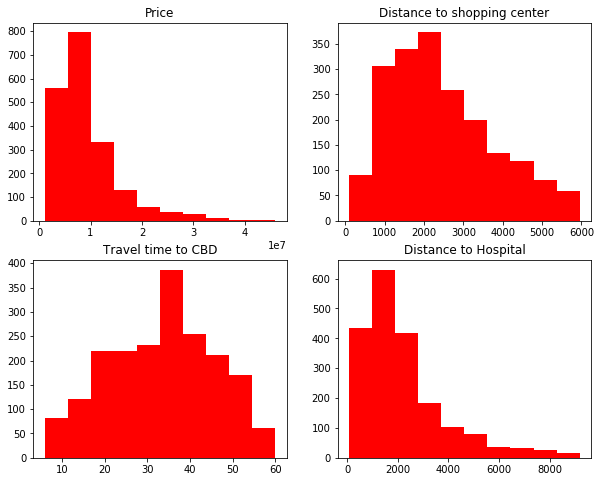

In [39]:
# select focusing records
selected_df = df[df.travel_min_to_CBD > 0]

# initial plot variables
fig = plt.figure(figsize=(10, 8))
axs = fig.subplots(2, 2)

# plot focusing columns such as price, Distance_to_sc, travel_min_to_CBD, Distance_to_hospital
axs[0,0].hist(selected_df.price, color='r')
axs[0,0].set_title('Price')

axs[0,1].hist(selected_df.Distance_to_sc, color='r')
axs[0,1].set_title('Distance to shopping center')

axs[1,0].hist(selected_df.travel_min_to_CBD, color='r')
axs[1,0].set_title('Travel time to CBD')

axs[1,1].hist(selected_df.Distance_to_hospital, color='r')
axs[1,1].set_title('Distance to Hospital')


### Analyse the plots.

From the figure above, the Attributes price, Distance to shopping center, and Distance to hospital are right-skewed, especially price and Distance to hospital, however, the Travel time to CBD is moderately symmetric which is acceptable in term of distribution.

### Apply transformation

Transforming data into normal distribution will support the training process of linear regression models. Hence, I will apply these functions as follow:

- Price attribute: log function will make big right-skewed data to be symmetric very well.
- Distance to shopping center attribute: square root function is appropriate with a small right-skewness.
- Travel time to CBD attribute: log function might work fine, however, for this one, power of 1/4 gives a better result.




In [40]:
# Tranforming data
selected_df['trnf_price'] = np.log(selected_df.price)
selected_df['trnf_Distance_to_sc'] = np.sqrt(selected_df.Distance_to_sc)
selected_df['trnf_travel_min_to_CBD'] = selected_df.travel_min_to_CBD
selected_df['trnf_Distance_to_hospital'] = np.power(selected_df.Distance_to_hospital, 0.25)


### The result in histrograms

Text(0.5, 1.0, '(Distance to Hospital)^1/4')

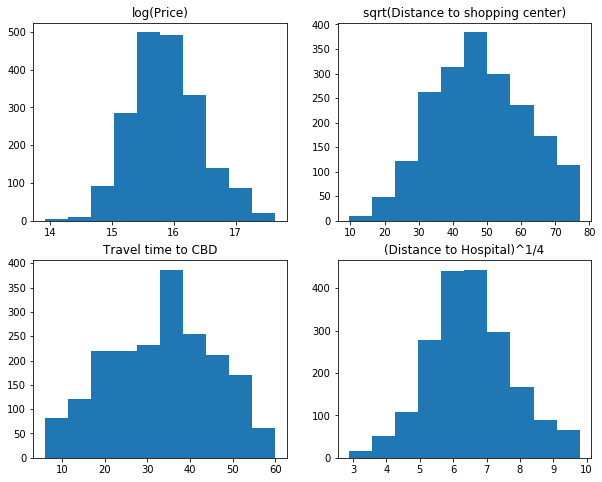

In [41]:
# initial plot
fig = plt.figure(figsize=(10, 8))
axs = fig.subplots(2, 2)

# plot the resutl after tranformation process
axs[0,0].hist(selected_df['trnf_price'])
axs[0,0].set_title('log(Price)')

axs[0,1].hist(selected_df['trnf_Distance_to_sc'])
axs[0,1].set_title('sqrt(Distance to shopping center)')

axs[1,0].hist(selected_df['trnf_travel_min_to_CBD'])
axs[1,0].set_title('Travel time to CBD')

axs[1,1].hist(selected_df['trnf_Distance_to_hospital'])
axs[1,1].set_title('(Distance to Hospital)^1/4') 

### The result in Q-Q plots

Text(0.5, 1.0, '(Distance to Hospital)^1/4')

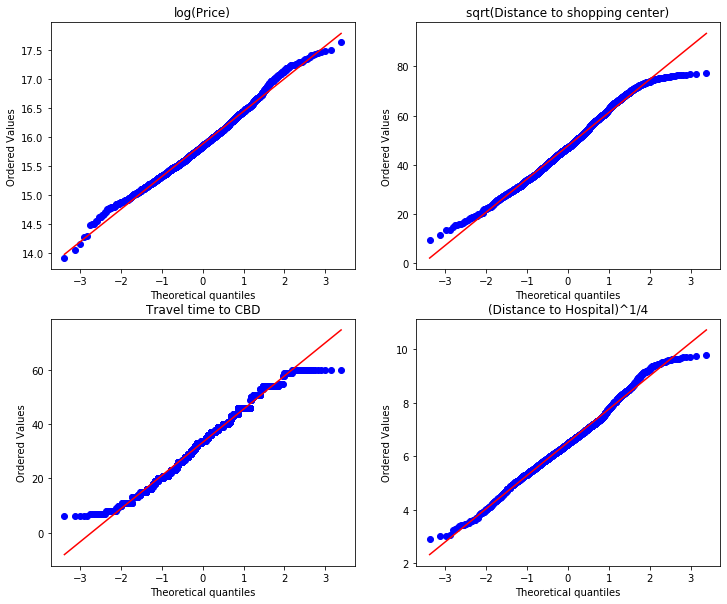

In [42]:
# initial plot
fig = plt.figure(figsize=(12, 10))
axs = fig.subplots(2, 2)

# plot the resutl after tranformation process
stats.probplot(selected_df['trnf_price'], dist="norm", plot=axs[0,0])
axs[0,0].set_title('log(Price)')

stats.probplot(selected_df['trnf_Distance_to_sc'], dist="norm", plot=axs[0,1])
axs[0,1].set_title('sqrt(Distance to shopping center)')

stats.probplot((selected_df['trnf_travel_min_to_CBD']), dist="norm", plot=axs[1,0])
axs[1,0].set_title('Travel time to CBD')

stats.probplot(selected_df['trnf_Distance_to_hospital'], dist="norm", plot=axs[1,1])
axs[1,1].set_title('(Distance to Hospital)^1/4') 

### The correlation of target vs transformed features

The distribution after transformation is better in term of a histogram. Now let check data in another perspective which is a scatter plot. I will plot each predictor versus target variable and residual to see the the distribution in correlation.



In [43]:
def plot_data(x, y, x_lab='X', y_lab='Y'):
    # initial variables
    fig = plt.figure(figsize=(8, 6))
    axs = fig.subplots(2, 1)

    # == plot predictor vs target variables ==
    axs[0].scatter(x, y)
    axs[0].set_title(y_lab + ' vs ' + x_lab)

    # create linear regression line
    m, b = np.polyfit(x, y, deg=1)
    axs[0].plot(x, m*x+b, color='red')

    # == Plot Residual ==
    res = y-(m*x+b)
    axs[1].scatter(x, res)
    axs[1].set_title('Residual vs ' + x_lab)

    # create linear regression line
    m, b = np.polyfit(x, res, deg=1)
    axs[1].plot(x, m*x+b, color='red')


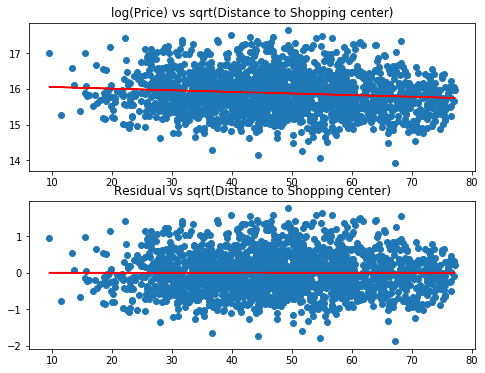

In [44]:
plot_data(selected_df.trnf_Distance_to_sc, selected_df.trnf_price, 
          'sqrt(Distance to Shopping center)', 'log(Price)')


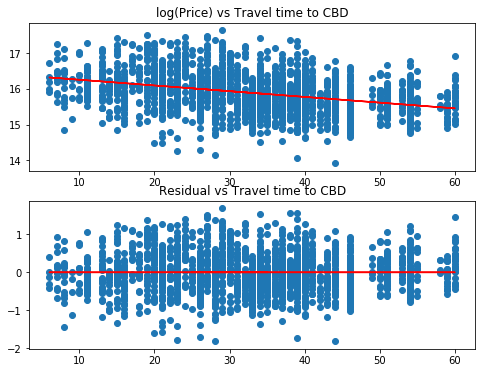

In [45]:
plot_data(selected_df.trnf_travel_min_to_CBD, selected_df.trnf_price, 
          'Travel time to CBD', 'log(Price)')


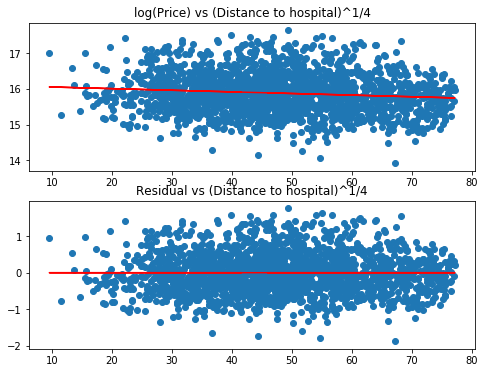

In [46]:
plot_data(selected_df.trnf_Distance_to_sc, selected_df.trnf_price, 
          '(Distance to hospital)^1/4', 'log(Price)')


## 3.2 Standardisation<a class="anchor" name="3.2"></a>

### Exploration

First, let see basic statistic each column with describe function and plot a line graph.


In [47]:
%matplotlib inline
# initital variables
feature_cols = ['trnf_Distance_to_sc', 'trnf_travel_min_to_CBD', 'trnf_Distance_to_hospital']
target_col = ['trnf_price']

# show statistic info of focusing attributes
selected_df[feature_cols + target_col].describe()

,trnf_Distance_to_sc,trnf_travel_min_to_CBD,trnf_Distance_to_hospital,trnf_price
count,1958.000000,1958.000000,1958.000000,1958.000000
mean,47.750566,33.392237,6.518975,15.879983
std,13.517033,12.312005,1.243002,0.562843
min,9.591663,6.000000,2.882121,13.914451
25%,37.973675,24.000000,5.713652,15.479437
50%,47.015954,34.000000,6.471997,15.850085
75%,57.805705,41.000000,7.245524,16.245477
max,77.181604,60.000000,9.791308,17.641976


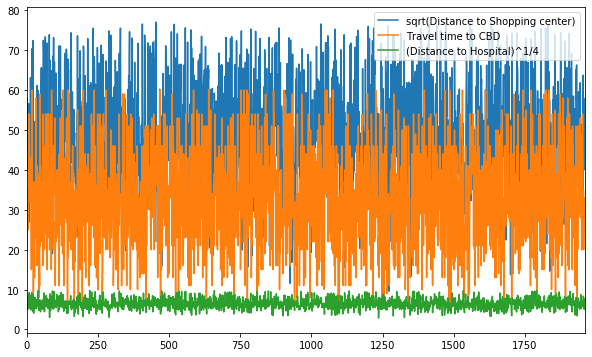

In [48]:
# plot a line graph
selected_df["trnf_Distance_to_sc"].plot(figsize=(10,6), label='sqrt(Distance to Shopping center)'), 
selected_df["trnf_travel_min_to_CBD"].plot(label='Travel time to CBD'), 
selected_df["trnf_Distance_to_hospital"].plot(label='(Distance to Hospital)^1/4')

# set legend
plt.legend(loc='upper right')

### Analyse the result

From the statistic information, it is obvious that all three features have different ranges of values. For instance, the `Distance to hospital^1/4` has a value between 2.8 and 9.7, whereas the `Travel time to CBD` is between 6 and 60. Since the Attributes which are the larger value will influence others, once training a model. Thus, to boost up the performance, those features should be normalised to be the same scale.


### Standardisation with z-score

There are several methods to normalise data such as min-max and z-score. For the min-max method, it will squeeze data in a range 0 and 1, so, the data will lose some information like detecting outliers. Thus, I would apply the z-score method in this task with preprocessing in sklearn library.


In [49]:
# scaling all features with preprocessing library
std_scale = preprocessing.StandardScaler().fit(selected_df[feature_cols])
df_std = std_scale.transform(selected_df[feature_cols])

# set scaled column names
scaled_cols = ['scaled_D2_SC', 'scaled_T2_CBD', 'scaled_D2_H']

# parse scaled data into dataframe
selected_df['scaled_D2_SC'] = df_std[:,0]  # 'D2_SC_scaled' is Distance_to_sc scaled
selected_df['scaled_T2_CBD'] = df_std[:,1] # 'T2_CBD_scaled' is travel_min_to_CBD scaled
selected_df['scaled_D2_H'] = df_std[:,2]   # 'D2_H_scaled' is Distance_to_hospital scaled

# show a sample result 
selected_df[feature_cols + scaled_cols].head()


,trnf_Distance_to_sc,trnf_travel_min_to_CBD,trnf_Distance_to_hospital,scaled_D2_SC,scaled_T2_CBD,scaled_D2_H
0,46.000000,35,8.343454,-0.129541,0.130618,1.468176
1,58.000000,20,6.254216,0.758454,-1.088016,-0.213054
2,52.810984,33,7.193705,0.374469,-0.031866,0.542962
3,51.410116,26,5.080057,0.270805,-0.600562,-1.157912
4,40.024992,33,7.636628,-0.571690,-0.031866,0.899386


In [50]:
# show basic statistic info
selected_df[scaled_cols].describe()


,scaled_D2_SC,scaled_T2_CBD,scaled_D2_H
count,1.958000e+03,1.958000e+03,1.958000e+03
mean,-4.849146e-16,1.373320e-16,-2.199608e-16
std,1.000255e+00,1.000255e+00,1.000255e+00
min,-2.823745e+00,-2.225408e+00,-2.926611e+00
25%,-7.234863e-01,-7.630468e-01,-6.480514e-01
50%,-5.436098e-02,4.937606e-02,-3.780363e-02
75%,7.440766e-01,6.180721e-01,5.846608e-01
max,2.177886e+00,2.161676e+00,2.633278e+00


Here we can see the scaled features are adjusted in the similar range and the mean values are very close to zero which means the data is significantly normal distributed.


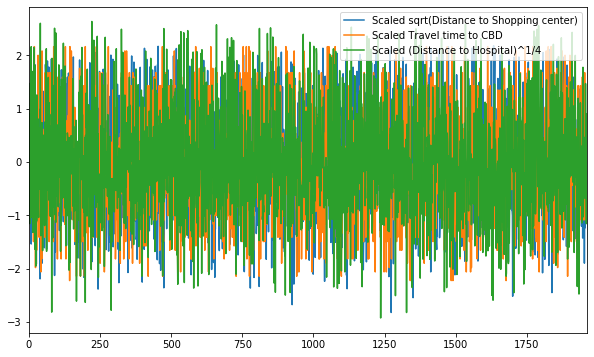

In [51]:
selected_df["scaled_D2_SC"].plot(figsize=(10,6), label='Scaled sqrt(Distance to Shopping center)'), 
selected_df["scaled_T2_CBD"].plot(label='Scaled Travel time to CBD'), 
selected_df["scaled_D2_H"].plot(label='Scaled (Distance to Hospital)^1/4')

plt.legend(loc='upper right')

### Evaluate result

After scaling transformed features, data align on the same scale clearly and this will improve performance when using this reshaped dataframe.


Text(0.5, 1.0, 'Tranformed: log(price)')

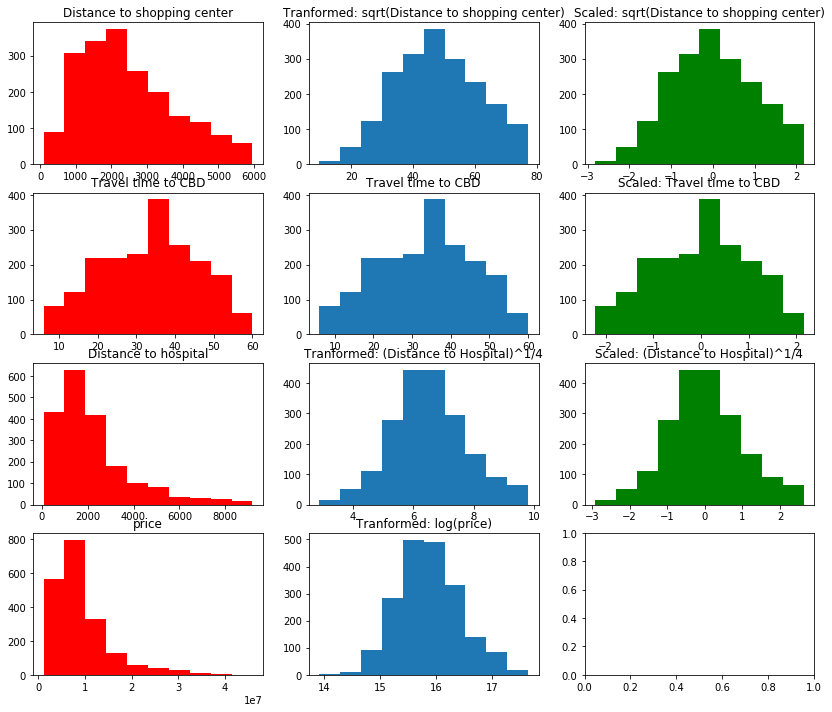

In [52]:
# compare with original data distribution

# initital plot
fig = plt.figure(figsize=(14, 12))
axs = fig.subplots(4, 3)

# plot changing each step of features
# Distance_to_sc
axs[0,0].hist(selected_df.Distance_to_sc, color='r')
axs[0,0].set_title('Distance to shopping center')
axs[0,1].hist(selected_df.trnf_Distance_to_sc)
axs[0,1].set_title('Tranformed: sqrt(Distance to shopping center)')
axs[0,2].hist(selected_df.scaled_D2_SC, color='g')
axs[0,2].set_title('Scaled: sqrt(Distance to shopping center)')

# travel_min_to_CBD
axs[1,0].hist(selected_df.travel_min_to_CBD, color='r')
axs[1,0].set_title('Travel time to CBD')
axs[1,1].hist(selected_df.trnf_travel_min_to_CBD)
axs[1,1].set_title('Travel time to CBD')
axs[1,2].hist(selected_df.scaled_T2_CBD, color='g')
axs[1,2].set_title('Scaled: Travel time to CBD')

# Distance_to_hospital
axs[2,0].hist(selected_df.Distance_to_hospital, color='r')
axs[2,0].set_title('Distance to hospital')
axs[2,1].hist(selected_df.trnf_Distance_to_hospital)
axs[2,1].set_title('Tranformed: (Distance to Hospital)^1/4')
axs[2,2].hist(selected_df.scaled_D2_H, color='g')
axs[2,2].set_title('Scaled: (Distance to Hospital)^1/4')

# Price
axs[3,0].hist(selected_df.price, color='r')
axs[3,0].set_title('price')
axs[3,1].hist(selected_df.trnf_price)
axs[3,1].set_title('Tranformed: log(price)')


## 3.3 Summary<a class="anchor" name="3.3"></a>

From the figure, we can notice how transformation effect a distribution of data, whereas, scaling will reserve the distribution as the same. Although, both standardisation and transformation are a significantly crucial process to make data ready before building an efficient linear regression model.


# 4. Conclusion<a class="anchor" name="4"></a>

In order to successfully complete a Data Integration and Reshaping process, a variety of skills is required. For instance, dealing with different file extensions and extract data, gathering datasets and merging data into one standard, transforming data to be ready to consume, etc. These are very significant knowledge for data scientists. Besides, it takes a vital portion of time in a development cycle and influences the quality of models additionally.



## Referances

- Barney, H. (2020). *How to Export Pandas DataFrame to CSV.* Retrieved from 
https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03

- Gillies, S. (2020) *The Shapely User Manual.* Retrieved from https://shapely.readthedocs.io/en/stable/manual.html

- Lakshmanan S. (2019). *How, When, and Why Should You Normalize / Standardize / Rescale Your Data?.* Retrieved from https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

- Naik, G. (2020). *Feature Engineering-How to Transform Data to Better Fit The Gaussian Distribution-Data Science.* Retrieved from https://www.youtube.com/watch?v=U_wKdCBC-w0

- Rocha, B. (2011). *Calculate distance between latitude longitude pairs with Python.* Retrieved from https://gist.github.com/rochacbruno/2883505

- Tenkanen, H. (2018). *Point in Polygon & Intersect.* Retrieved from https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html

- statisticssolutions.com. (n.d.). *Assumptions of Linear Regression.* Retrieved from https://www.statisticssolutions.com/assumptions-of-linear-regression/?__cf_chl_jschl_tk__=013839d4c821f1d6e68b5804454de5b8c3c25ae3-1605681117-0-Acr7E-0G-yMEzxt6sOs7LYel39Xi9PyamRHjkwP9xcMtkYWncPugTEx9tkfhh5iyHAX8J3LUBFNe-Avf-xs3-PFWg1h4RpJz8Lmd2CIhhZpGiLQplH_xezfKW4DOfc_sb31zQOLpONaMzuFbZfOAT5sX2CIiYl52kYdByojLf8MTwyGqANpwj_PMqTNmrjJVkSkjq1R_-sDq-rUJ31xfU4Oes6UKdDU-_uh_vM21MXDD20F1ROwl9MXMI2hXQlDr8U4HDtQ2uXqfRL7qr3UTF6c0NuP5Aw_T4LiMUy46SObOIAppw82UvVtp4ShsgE4cipcZJtcXe1pDrYIko9PI5K3PCyhdBs81Pg46ZxmQP76d